In [24]:
import os
import uuid

os.environ['HF_HOME'] = 'hf_cache'

import matplotlib.pyplot as plt

from model.modeling_llama import LlamaForCausalLM as ModifiedLlama
from transformers import AutoTokenizer, AutoModelForCausalLM
from kvcache.iterative import IterativeReduceKVBiasCache as ModifiedCache, IterativeReduceKVBiasCache
from transformers import DynamicCache
from datasets import load_dataset

import torch
import numpy as np
import random

import torch.nn.functional as F
import time
from IPython.display import DisplayHandle

import os
import random
import pandas as pd

import seaborn as sns

DEVICE = 'mps'
DTYPE = torch.bfloat16
FIRST_N = 10000
SAMPLE_SIZE = 2
MAX_LENGTH = 100
PROTECT_FIRST = 20

In [25]:
torch.cuda.is_available()

False

In [26]:
# Define the cache file name
CACHE_FILENAME = f"fineweb_sample{SAMPLE_SIZE}of{FIRST_N}.csv"

# Check if the cache file already exists
if os.path.exists(CACHE_FILENAME):
    print(f"Cache file already exists: {CACHE_FILENAME}")
    df = pd.read_csv(CACHE_FILENAME)
else:
    # Load streaming dataset
    dataset = load_dataset("HuggingFaceFW/fineweb-edu", split="train", name="sample-10BT", streaming=True)
    stream = iter(dataset)

    samples = [next(stream) for _ in range(FIRST_N)]
    selected_samples = random.sample(samples, SAMPLE_SIZE)

    # Convert to DataFrame
    df = pd.DataFrame(selected_samples)

    # Save to CSV
    df.to_csv(CACHE_FILENAME, index=False, encoding="utf-8")
    print(f"Saved CSV with {len(df)} samples to: {CACHE_FILENAME}")

texts = df["text"]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Resolving data files:   0%|          | 0/2110 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saved CSV with 2 samples to: fineweb_sample2of10000.csv


In [58]:
def get_cache_size(cache: DynamicCache | ModifiedCache, max_len: int):
    n_layers = len(cache.key_cache)
    n_heads = len(cache.key_cache[0][0])
    
    if not isinstance(cache, ModifiedCache):
        yield {'Cache Size (% of max)': 100}
    else:
        layer_sum = 0
        n_layers = 0
        for layer, last_available_per_head in enumerate(cache.last_available_idx):
            last_available_per_head = last_available_per_head[0]
            layer_max = 0
            for head, last_available in enumerate(last_available_per_head):
                layer_max = max(layer_max, 100 * (min(last_available.item() + 1, max_len) / max_len))

            layer_sum += layer_max
            n_layers += 1
        
        yield {'Cache Size (% of max)': layer_sum / n_layers}


def eval_match_ignored_order(pred: set[int], gold: set[int]) -> float:
    same = gold.intersection(pred)
    return 100 * len(same) / len(gold)
                

def stepwise_perplexity(
        model, tokenizer, texts, cache_impl, 
        gold: list[set[int]] = None, 
        update_every=10, 
        max_length=MAX_LENGTH,
        seed_run: bool = False
):
    loss_fn = torch.nn.CrossEntropyLoss()

    total_texts = len(texts)

    display_handle = DisplayHandle()
    display_handle.display("Starting perplexity evaluation...")
    
    # track: PPL, Text Idx, Step, Cache Class
    results = []
    
    # track: Cache Size (% of max), Layer ID, Head ID, Text Idx, Step
    results_cache = []

    gold_iter = iter(gold) if gold is not None else None
    
    seed_tokens = torch.tensor([], dtype=torch.long)
    if seed_run:
        seed = str(uuid.uuid4()) + '\n\n'
        seed_tokens = tokenizer([seed], return_tensors="pt", truncation=True, max_length=max_length)["input_ids"].squeeze(0)

    for text_idx, text in enumerate(texts):
        enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        input_ids = torch.concat([seed_tokens, enc["input_ids"].squeeze(0)]).to(DEVICE)
        cache = cache_impl()
        
        if isinstance(cache, ModifiedCache):
            cache_class = cache.__class__.__name__ + f"(MVI={cache.max_variance_increase:.1f}, PF={cache.protect_first})"
        else:
            cache_class = "Normal"
        
        if seed_run:
            cache_class += " Seeded"
        
        seq_len = input_ids.size(0)
        main_seq_len = seq_len - (seed_tokens.size(0) if seed_run else 0)
        
        total_loss = 0.0
        total_tokens = 0
        
        skip_count = 0
        if seed_run:
            skip_count = seed_tokens.size(0)

        # Autoregressive token-by-token loop
        for i in range(1, seq_len):
            input_slice = input_ids[i - 1 : i].unsqueeze(0)  # [1, 1]
            label_token = input_ids[i].unsqueeze(0)          # [1]

            with torch.no_grad():
                output = model(
                    input_ids=input_slice,
                    use_cache=True,
                    past_key_values=cache,
                    cache_position=torch.tensor([i - 1], device=DEVICE, dtype=torch.long),
                )
                cache = output.past_key_values
                logits = output.logits[:, -1, :]  # [1, vocab_size]
                
            if skip_count <= 0:
                loss = loss_fn(logits, label_token)
                total_loss += loss.item()
                total_tokens += 1
    
                # Update the display every update_every steps
                if total_tokens % update_every == 0 or (i == seq_len - 1 and text_idx == total_texts - 1):
                    current_ppl = np.exp(total_loss / total_tokens)
                    status = (f"Text {text_idx + 1}/{total_texts} | "
                              f"Token {i + 1}/{seq_len} | "
                              f"Global Steps: {total_tokens} | "
                              f"Cumulative PPL: {current_ppl:.2f}")
                    display_handle.update(status)
            
                # Append current results:
                # For each token, we collect the current perplexity estimate, the cache class, 
                # the text index, and the current step number.
                top_5 = logits.topk(k=5)[1][0].tolist()
                results.append({
                    "Top 5 Tokens": top_5,
                    "MatchUnordered@5": eval_match_ignored_order(set(top_5), next(gold_iter)) if gold_iter is not None else 100.0,
                    "PPL": np.exp(total_loss / total_tokens),
                    "Cache Class": cache_class,
                    "Text Idx": text_idx,
                    "Step": i - (seed_tokens.size(0) if seed_run else 0)
                })
                
                results_cache.extend([
                    {
                        "Text Idx": text_idx,
                        "Step": i - (seed_tokens.size(0) if seed_run else 0),
                        "Cache Class": cache_class,
                        **d
                    }
                    for d in get_cache_size(cache, max_len=i)  
                ])
            
            skip_count -= 1

    return results, results_cache

def get_gold(res: list[dict]) -> list[set[int]]:
    collected = []
    for datapoint in res:
        collected.append(set(datapoint["Top 5 Tokens"]))
    return collected

In [59]:
def plot(data, target="PPL", ylim=None, rolling_window=None):
    """
    Plots the specified target over steps from the given data. Optionally 
    applies a window-based rolling mean to smooth the plot.

    :param data: List of dictionaries or a Pandas DataFrame that must include
                 columns 'Step', 'Cache Class', and <target>.
    :param target: The target column to plot (e.g. "PPL").
    :param ylim: A tuple (min, max) that specifies the y-axis range.
    :param smoothing_window: Size of the rolling window for smoothing. If set 
                            to None, no smoothing is applied.
    """
    df = pd.DataFrame(data)

    # Optionally apply smoothing
    if rolling_window is not None and rolling_window > 1:
        df[target] = df.groupby(["Cache Class", "Text Idx"])[target] \
                       .transform(lambda s: s.rolling(rolling_window, min_periods=1).mean())

    plt.figure(figsize=(12, 7))
    sns.lineplot(x="Step", y=target, hue="Cache Class", data=df)
    if ylim:
        plt.ylim(ylim)
    plt.title(f"{target} vs. Step" + (f" (Rolling Window = {rolling_window})" if rolling_window else ""))
    plt.show()
    
    
def plot_cache(data):
    plt.figure(figsize=(12, 7))
    sns.lineplot(y="Cache Size (% of max)", x="Step", data=pd.DataFrame(data), hue="Cache Class")

In [60]:
#texts = [texts[0]]

In [61]:
model_hf = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M")
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

In [62]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None)
gold = get_gold(results)
gold[:10]

'Text 2/2 | Token 100/100 | Global Steps: 99 | Cumulative PPL: 13.28'

[{29, 30, 449, 726, 2192},
 {339, 378, 942, 1073, 1812},
 {359, 416, 457, 699, 2316},
 {28, 42, 253, 549, 563},
 {1048, 1142, 1962, 2029, 4061},
 {28, 30, 282, 284, 327},
 {216, 253, 260, 354, 1885},
 {28, 1495, 2396, 2966, 6031},
 {476, 1495, 1838, 2029, 6031},
 {413, 11052, 13013, 13216, 32458}]

'Text 2/2 | Token 136/136 | Global Steps: 99 | Cumulative PPL: 13.17'

'Text 2/2 | Token 134/134 | Global Steps: 99 | Cumulative PPL: 13.16'

'Text 2/2 | Token 134/134 | Global Steps: 99 | Cumulative PPL: 13.08'

'Text 2/2 | Token 134/134 | Global Steps: 99 | Cumulative PPL: 13.05'

'Text 2/2 | Token 134/134 | Global Steps: 99 | Cumulative PPL: 13.19'

'Text 2/2 | Token 135/135 | Global Steps: 99 | Cumulative PPL: 12.97'

'Text 2/2 | Token 136/136 | Global Steps: 99 | Cumulative PPL: 13.15'

'Text 2/2 | Token 134/134 | Global Steps: 99 | Cumulative PPL: 13.07'

'Text 2/2 | Token 134/134 | Global Steps: 99 | Cumulative PPL: 12.91'

'Text 2/2 | Token 135/135 | Global Steps: 99 | Cumulative PPL: 13.19'

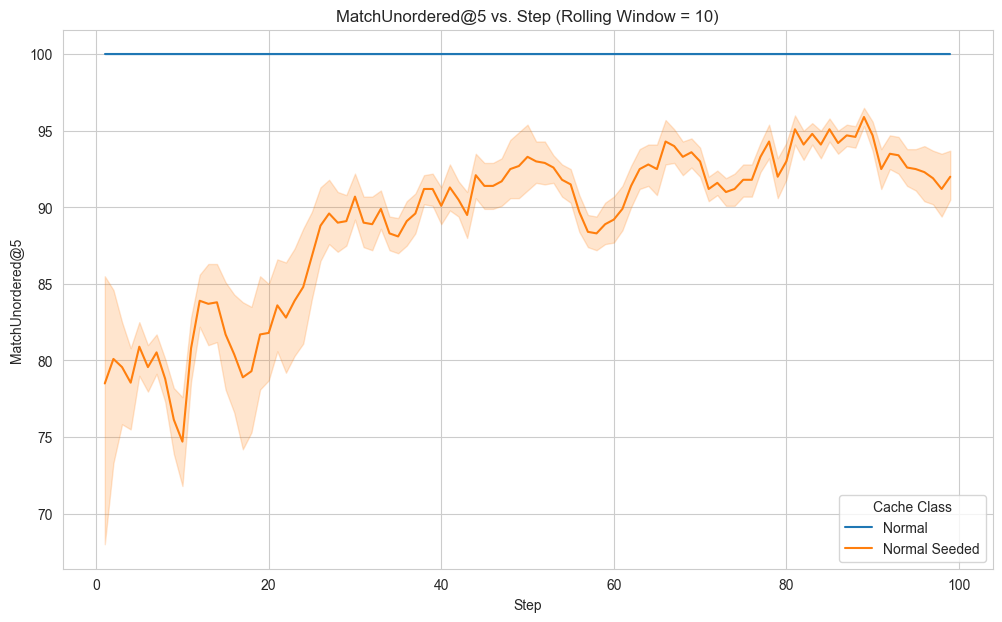

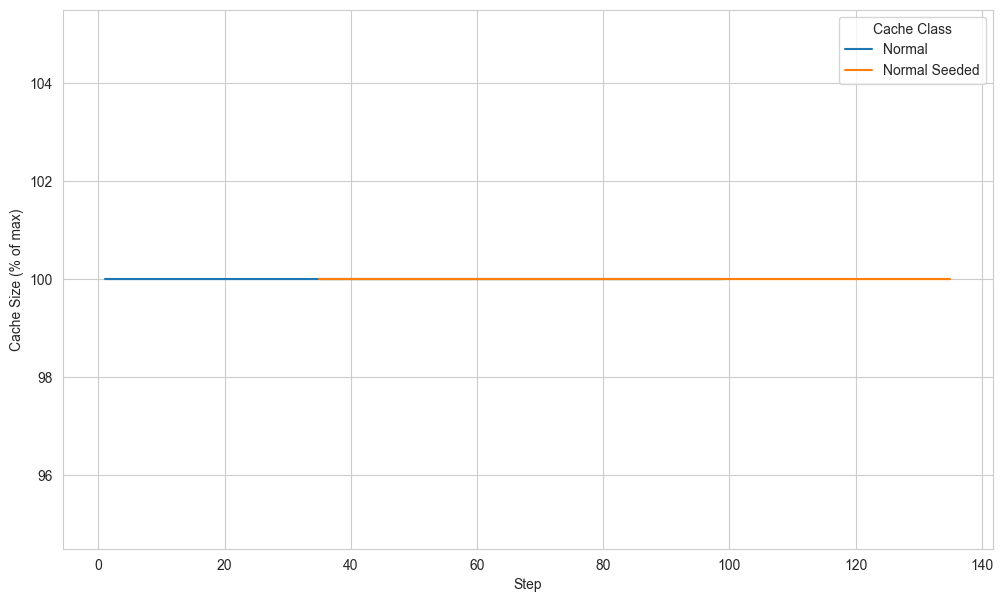

In [63]:
# compute normal variations of the metric
for _ in range(10):
    res, resc = stepwise_perplexity(model_hf, tokenizer, texts, gold=gold, cache_impl=lambda: None, seed_run=True)
    results += res
    results_cache += resc
    
plot(results, target="MatchUnordered@5", rolling_window=10)
plot_cache(results_cache)

In [65]:
model_mod = ModifiedLlama.from_pretrained("HuggingFaceTB/SmolLM2-135M", attn_implementation="eager")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

'Text 2/2 | Token 100/100 | Global Steps: 99 | Cumulative PPL: 13.25'

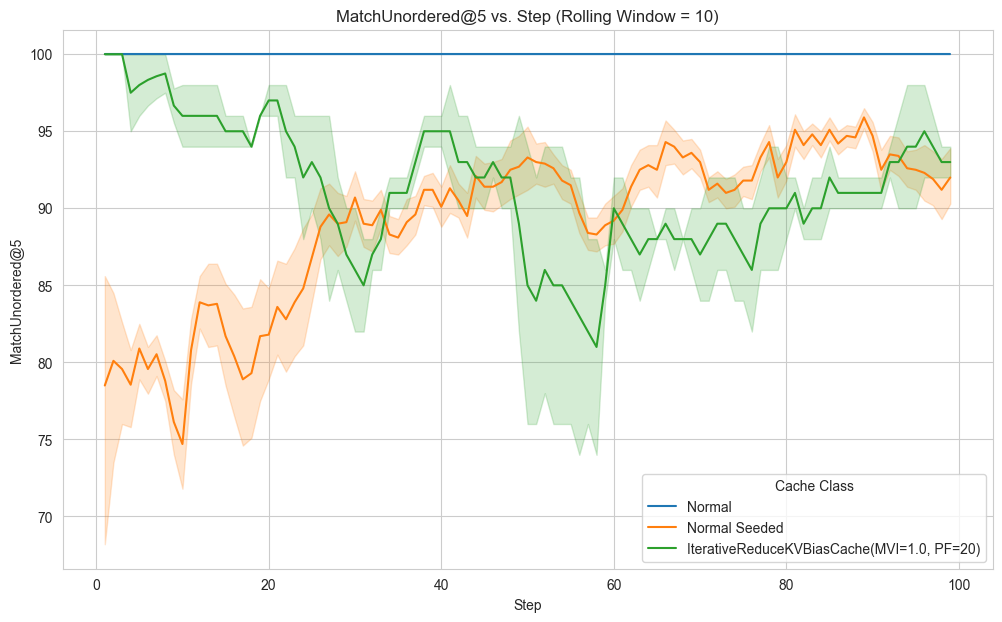

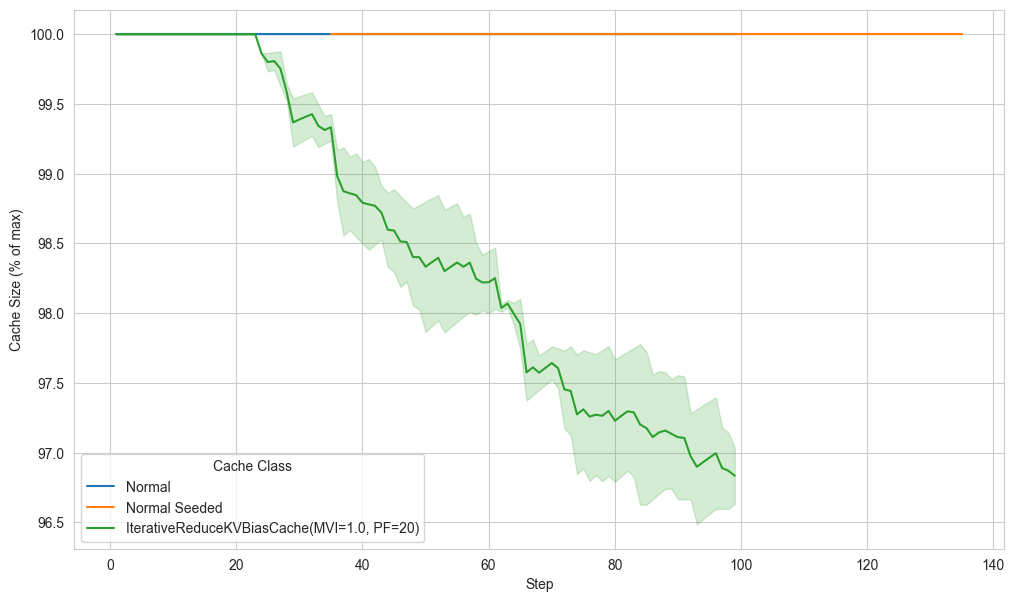

In [66]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=1.0, protect_first=PROTECT_FIRST), update_every=1)
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=10)
plot_cache(results_cache)

'Text 2/2 | Token 100/100 | Global Steps: 99 | Cumulative PPL: 14.00'

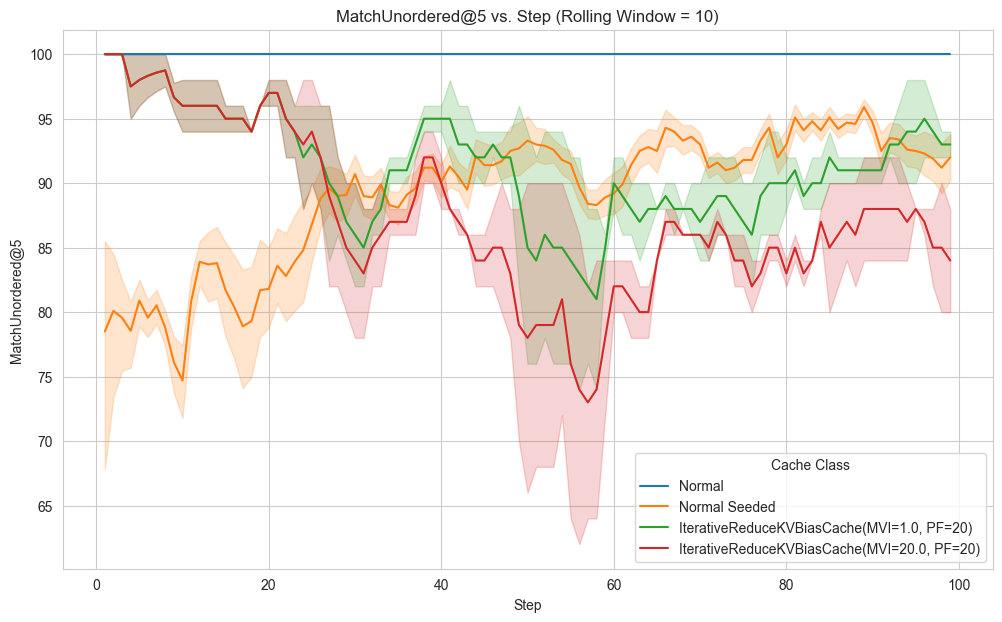

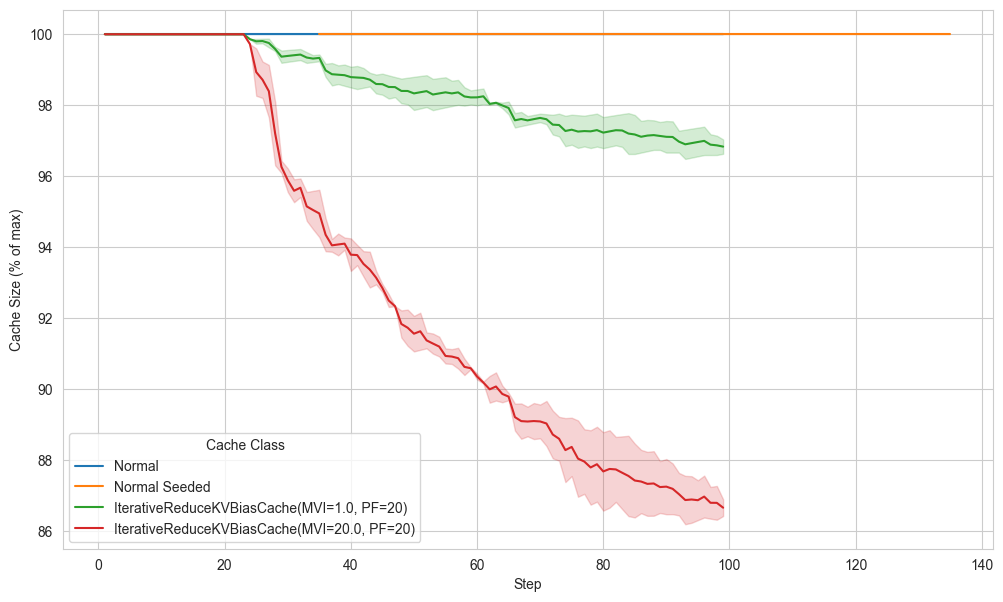

In [67]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=20.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=10)
plot_cache(results_cache)

'Text 2/2 | Token 100/100 | Global Steps: 99 | Cumulative PPL: 15.00'

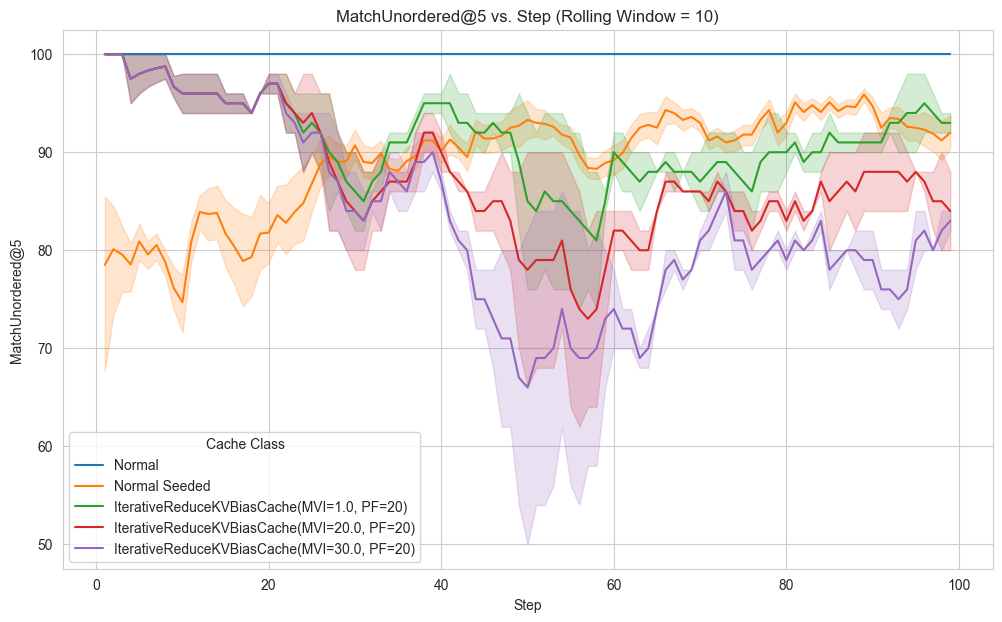

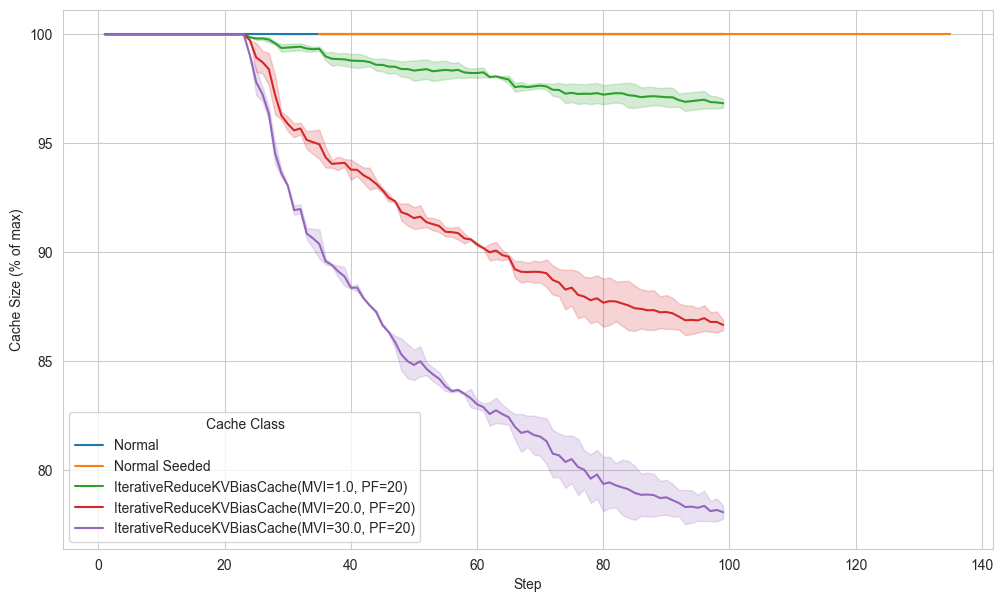

In [68]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=30.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=10)
plot_cache(results_cache)

'Text 2/2 | Token 100/100 | Global Steps: 99 | Cumulative PPL: 19.77'

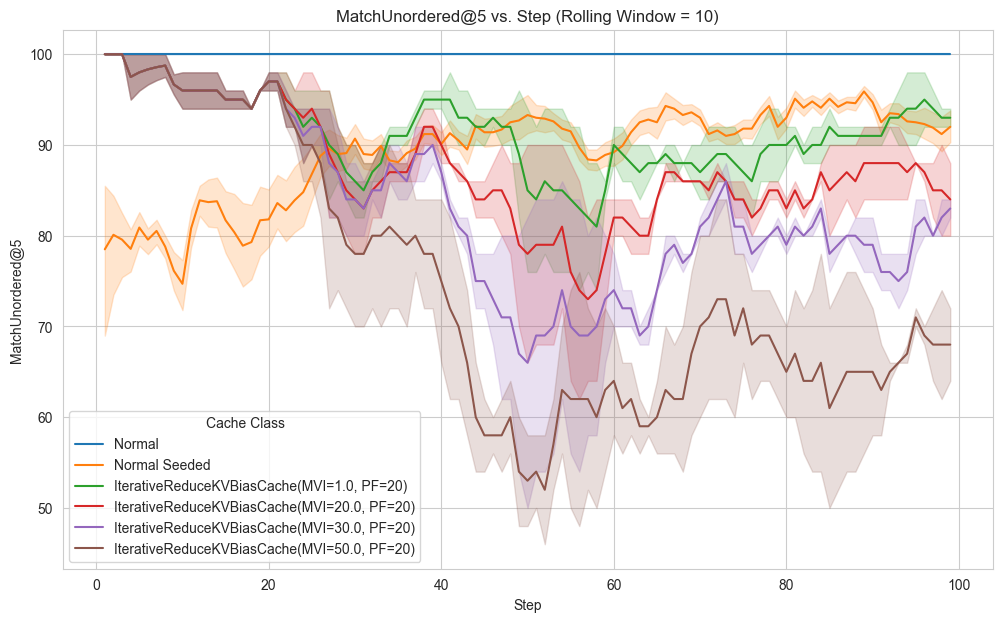

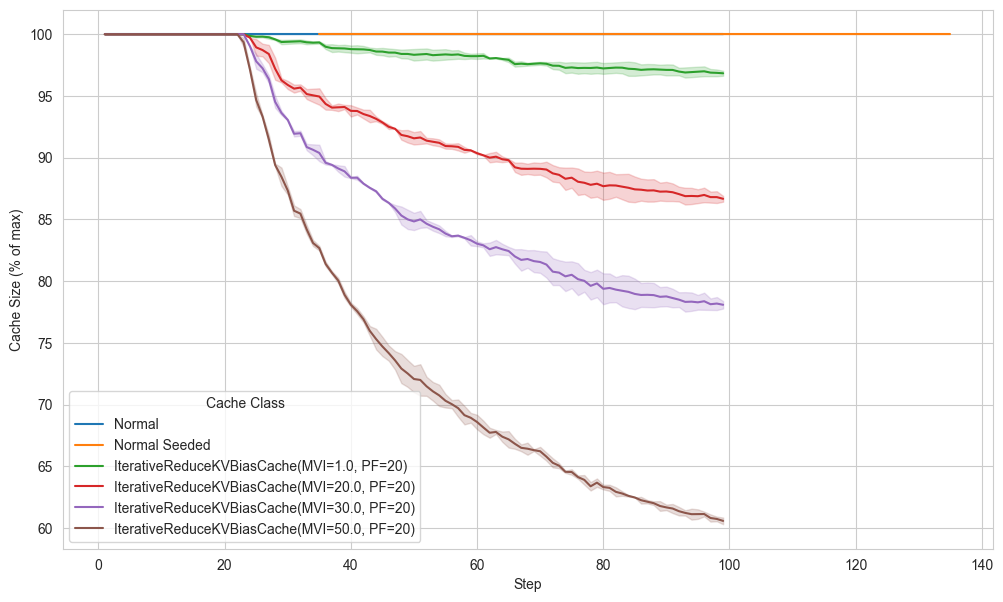

In [69]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=50.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=10)
plot_cache(results_cache)

In [ ]:
MODEL = 'meta-llama/Meta-Llama-3-8B'
model_hf = AutoModelForCausalLM.from_pretrained(MODEL)
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None)
gold = get_gold(results)
gold[:10]

In [ ]:
model_mod = ModifiedLlama.from_pretrained(MODEL, attn_implementation="eager")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=10.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=20.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=30.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=50.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=100.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=120.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_variance_increase=150.0, protect_first=PROTECT_FIRST))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
print(texts[0])

In [ ]:
def stepwise_generate(model, tokenizer, prompt, cache_impl, update_every=10, n_generate=100):
    display_handle = DisplayHandle()
    display_handle.display("Starting generation...")

    enc = tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"].squeeze(0).to(model.device)
    cache = cache_impl()
    
    seq_len = input_ids.size(0)

    # Autoregressive token-by-token loop
    for i in range(1, seq_len + n_generate):
        input_slice = input_ids[i - 1 : i].unsqueeze(0)  # [1, 1]

        with torch.no_grad():
            output = model(
                input_ids=input_slice,
                use_cache=True,
                past_key_values=cache,
                cache_position=torch.tensor([i - 1], device=DEVICE, dtype=torch.long),
            )
            cache = output.past_key_values
            logits = output.logits[0, -1, :]  # [vocab_size]
            predicted_token = logits.argmax(dim=-1)
            
            if i >= len(input_ids):
                input_ids = torch.cat((input_ids, predicted_token.unsqueeze(0)), dim=-1)

        # Update the display every update_every steps
        status = tokenizer.decode(input_ids)
        display_handle.update(status)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_variance_increase=50.0, protect_first=PROTECT_FIRST))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_variance_increase=0.0, protect_first=PROTECT_FIRST))

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(max_variance_increase=20.0, protect_first=PROTECT_FIRST))